In [1]:
import numpy as np
import netCDF4 as ncdf
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import glob as glob
import os as os
import sys as sys
from filter.RaymondFilters import RaymondFilter6, RaymondFilter10
#from filter import raymond2d_lowpass as RaymondFilter6

# These are 45 vertical levels that the FV3 puts out - use them here to map ARW to that grid for comparison

plevels = np.asarray([100000.,  97500.,  95000.,  92500.,  90000.,  87500.,  85000.,  82500.,
                       80000.,  77500.,  75000.,  72500.,  70000.,  67500.,  65000.,  62500.,
                       60000.,  57500.,  55000.,  52500.,  50000.,  47500.,  45000.,  42500.,
                       40000.,  37500.,  35000.,  32500.,  30000.,  27500.,  25000.,  22500.,
                       20000.,  17500.,  15000.,  12500.,  10000.,   7000.,   5000.,   3000.,
                        2000.,   1000.,    700.,    500.,    200.])
nz_new = plevels.shape[0]

klevel = 25
plevel = plevels[klevel]

utc = 23

HRRR_data_set = ("/work/wicker/27May_2021_HRRR/region.20210504_conus_hrrr.t00z.wrfnatf%2.2i.nc4" % utc)
RRFS_data_set = ("/work/wicker/04May_2021_RRFS/mem1/region.t00z.mem01.naf%3.3i.nc4" % utc)

HRRR_data_set = ("/Users/Louis.Wicker/CAM_Case_Studies/20210526/HRRR/region_202105261200_F%2.2i.nc" % (utc-12))
RRFS_data_set = ("/Users/Louis.Wicker/CAM_Case_Studies/20210526/RRFS/nord3/conus_F%2.2i.nc" % (utc-12))

def title_string(time, pres, label, wmax, wmin, eps=None):
    if eps:
        return ("%2.2i UTC %s at Pres=%3.0f mb with EPS=%5.1f \n Wmax: %3.1f        Wmin: %4.2f" % (time, label, pres/100., eps, wmax, wmin))
    else:
        return ("%2.2i UTC %s at Pres=%3.0f mb \n Wmax: %3.1f        Wmin: %4.2f" % (time, label, pres/100., wmax, wmin))

In [2]:
%load_ext autoreload
%autoreload 2

Text(0.5, 1.0, '23 UTC RRFS-mem1 Unfiltered W at Pres=375 mb \n Wmax: 38.1        Wmin: -4.79')

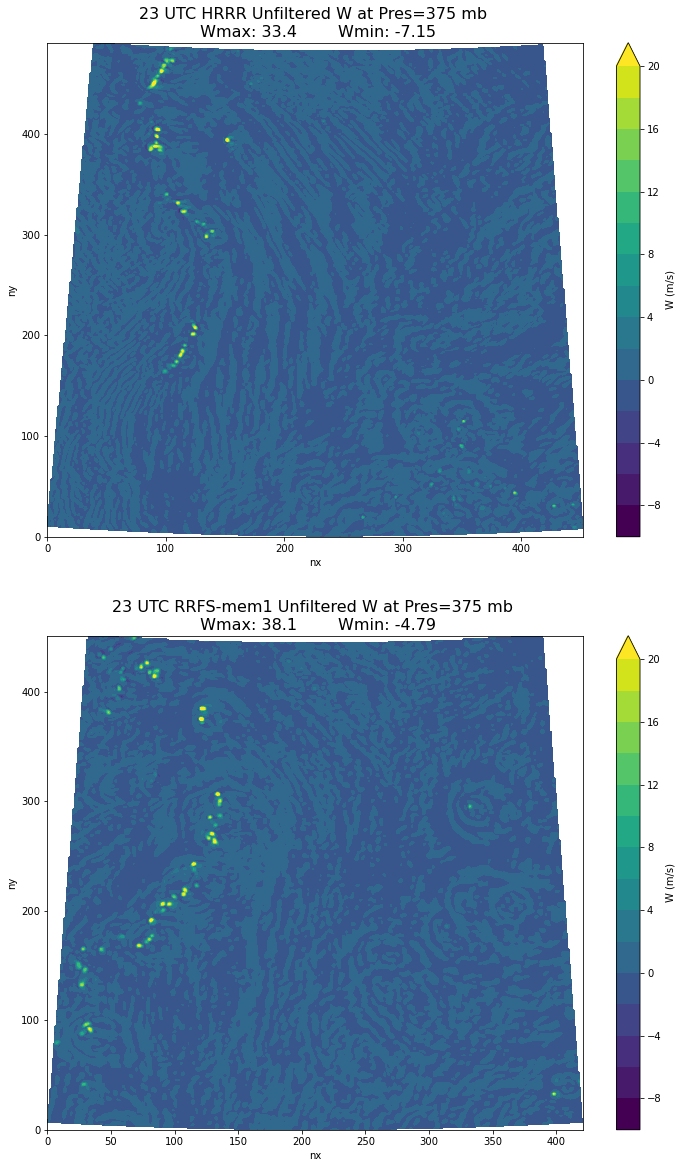

In [3]:
f = xr.open_dataset(HRRR_data_set)


g = xr.open_dataset(RRFS_data_set)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,20))
ylim = None
xlim = None

colormap = 'viridis'

if klevel < 10:
    vmin = -5.
    vmax = 10.
    clevels = np.linspace(vmin, vmax, 16)
else:
    vmin = -10.
    vmax = 20.
    clevels = np.linspace(vmin, vmax, 16)

# Plot the HRRR data

f.W.isel(nz=klevel).plot.contourf(ax=axes[0], levels=clevels, xlim=xlim, ylim=ylim, cmap=colormap, cbar_kwargs={'label': 'W (m/s)'})
axes[0].set_title(title_string(utc, plevel, 'HRRR Unfiltered W', f.W.isel(nz=klevel).max(), f.W.isel(nz=klevel).min()), fontsize=16)
g.W.isel(nz=klevel).plot.contourf(ax=axes[1], levels=clevels, xlim=xlim, ylim=ylim, cmap=colormap, cbar_kwargs={'label': 'W (m/s)'})
axes[1].set_title(title_string(utc, plevel, 'RRFS-mem1 Unfiltered W', g.W.isel(nz=klevel).max(), g.W.isel(nz=klevel).min()), fontsize=16)


In [4]:
fw_tmp = np.nan_to_num((f.W.values).astype('float64'))
fw_tmp2 = np.zeros_like(fw_tmp)

f.variables['W'][...] = np.nan_to_num(f.W)

gw_tmp = np.nan_to_num((g.W.values).astype('float64'))
gw_tmp2 = np.zeros_like(gw_tmp)

g.variables['W'][...] = np.nan_to_num(g.W)


In [20]:
# Test 2D filtering with various filters.

from filter.RaymondFilters import RaymondFilter6F, inverseRaymondResponse, RaymondFilter10
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats

npass = 1

eps_values = inverseRaymondResponse(0.9, [14, 12, 10, 8], order=10, npass=npass)

eps = eps_values[2]

print(eps)

fw_tmp2 = RaymondFilter10(fw_tmp, eps, npass = npass, klevels = [23,klevel,27])
    
fw_tmp2 = f.W.copy(data=(fw_tmp-fw_tmp2))

#

gw_tmp2 = RaymondFilter10(gw_tmp, eps, npass = npass, klevels = [klevel])

gw_tmp2 = g.W.copy(data=(gw_tmp-gw_tmp2))


8472.217668485728
RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS = 1 is only implementation!!! 

RaymondFilter10: KLEVELS arg supplied, only filtering levels: [23, 25, 27] 

RaymondFilter10:  Finished the Y-PASS 

Loop for 3D array took 7.0024 seconds

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS = 1 is only implementation!!! 

RaymondFilter10: KLEVELS arg supplied, only filtering levels: [25] 

RaymondFilter10:  Finished the Y-PASS 

Loop for 3D array took 1.7086 seconds



Text(0.5, 1.0, '23 UTC RRFS-mem1 High Pass Filter W at Pres=375 mb with EPS=8472.2 \n Wmax: 25.1        Wmin: -9.52')

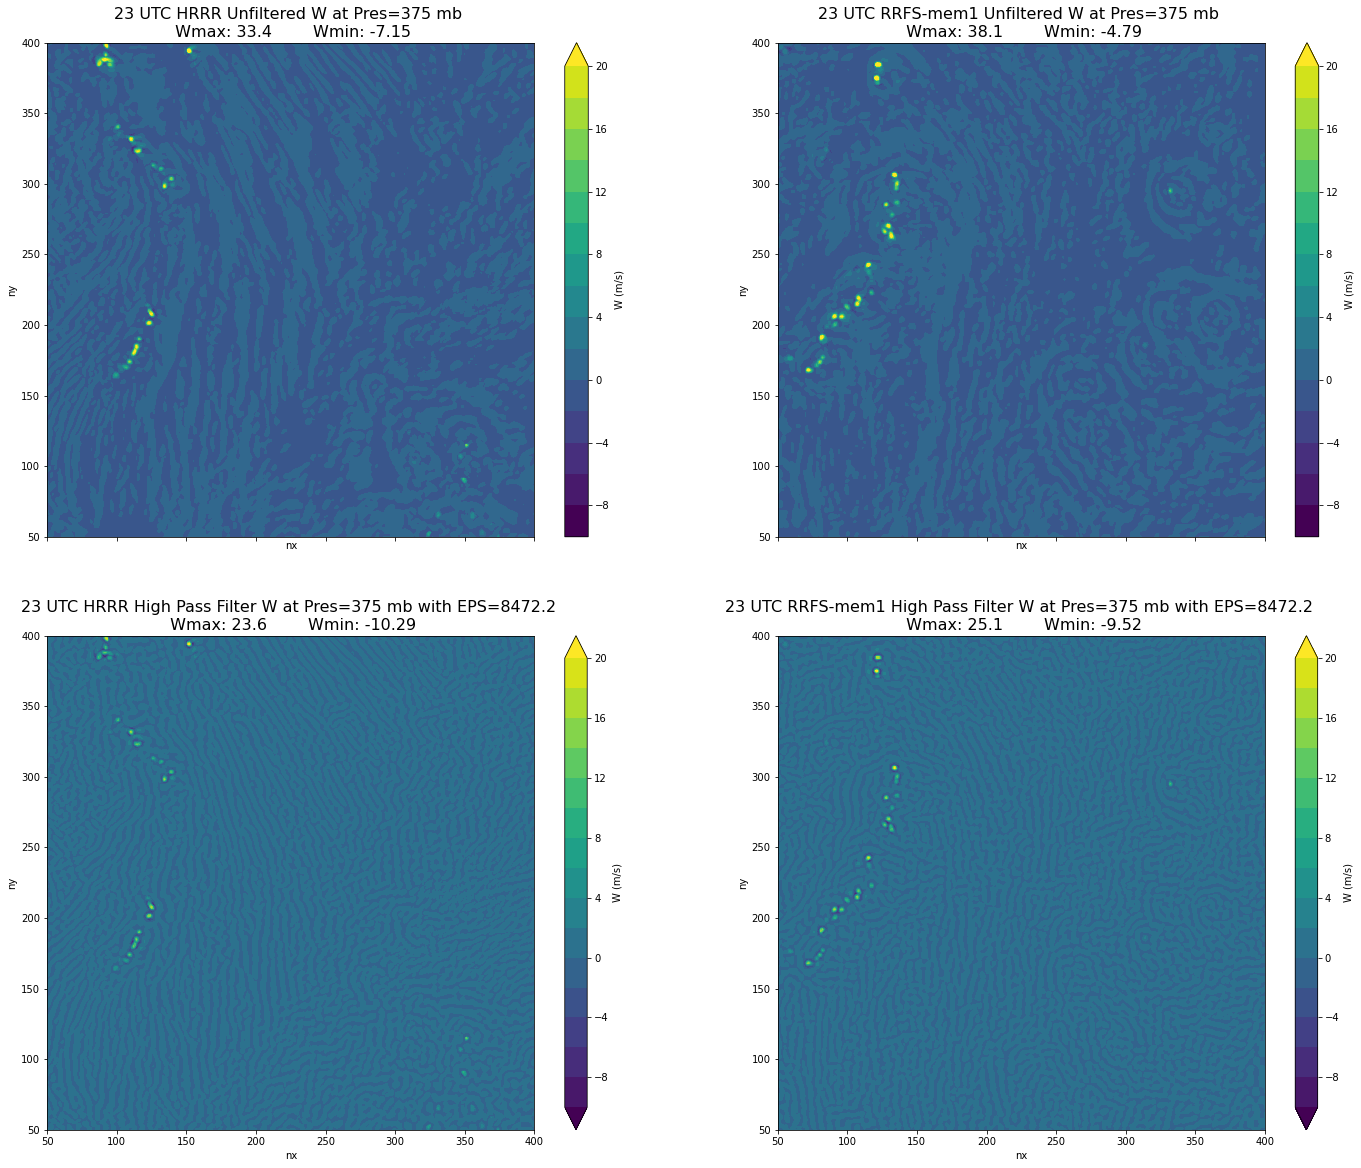

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,20), sharex=True)
xlim = [50,400]
ylim = [50,400]

colormap = 'viridis'

if klevel < 10:
    vmin = -5.
    vmax = 10.
    clevels = np.linspace(vmin, vmax, 16)
else:
    vmin = -10.
    vmax = 20.
    clevels = np.linspace(vmin, vmax, 16)

# Plot the HRRR data

f.W.isel(nz=klevel).plot.contourf(ax=axes[0,0], levels=clevels, xlim=xlim, ylim=ylim, cmap=colormap, cbar_kwargs={'label': 'W (m/s)'})
axes[0,0].set_title(title_string(utc, plevel, 'HRRR Unfiltered W', f.W.isel(nz=klevel).max(), f.W.isel(nz=klevel).min()), fontsize=16)

fw_tmp2.isel(nz=klevel).plot.contourf(ax=axes[1,0], levels=clevels, xlim=xlim, ylim=ylim, cmap=colormap, cbar_kwargs={'label': 'W (m/s)'})
axes[1,0].set_title(title_string(utc, plevel, 'HRRR High Pass Filter W', 
                    fw_tmp2.isel(nz=klevel,
                                 nx=np.arange(xlim[0],xlim[1]),
                                 ny=np.arange(ylim[0],ylim[1])).max(),
                    fw_tmp2.isel(nz=klevel,
                                 nx=np.arange(xlim[0],xlim[1]), 
                                 ny=np.arange(ylim[0],ylim[1])).min(), eps=eps), fontsize=16)

g.W.isel(nz=klevel).plot.contourf(ax=axes[0,1], levels=clevels, xlim=xlim, ylim=ylim, cmap=colormap, cbar_kwargs={'label': 'W (m/s)'})
axes[0,1].set_title(title_string(utc, plevel, 'RRFS-mem1 Unfiltered W', g.W.isel(nz=klevel, nx=np.arange(0,300)).max(), g.W.isel(nz=klevel).min()), fontsize=16)

gw_tmp2.isel(nz=klevel).plot.contourf(ax=axes[1,1], levels=clevels, xlim=xlim, ylim=ylim, cmap=colormap, cbar_kwargs={'label': 'W (m/s)'})
axes[1,1].set_title(title_string(utc, plevel, 'RRFS-mem1 High Pass Filter W', 
                    gw_tmp2.isel(nz=klevel,
                                 nx=np.arange(xlim[0],xlim[1]),
                                 ny=np.arange(ylim[0],ylim[1])).max(),
                    gw_tmp2.isel(nz=klevel,
                                 nx=np.arange(xlim[0],xlim[1]), 
                                 ny=np.arange(ylim[0],ylim[1])).min(), eps=eps), fontsize=16)


In [16]:
kl = [k for k in np.arange(50)]

In [17]:
kl

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]